## Imports

In [1]:
import os
import matplotlib.pyplot as plt
import SimpleITK as sitk
import numpy as np
import pandas as pd
from glob import glob
import nibabel as nib
import torch

import monai
from monai.data import PILReader, ImageDataset, create_test_image_3d, decollate_batch, DataLoader
from monai.inferers import sliding_window_inference
from monai.data.image_reader import ITKReader
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    RandRotate90,
    RandSpatialCrop,
    ScaleIntensity,
    LoadImage,
    LoadImaged, 
    Resized, 
    SaveImage
)
from monai.visualize import plot_2d_or_3d_image


## Experimental Visualizations of Data

In [2]:
data_dir = 'data/PROMISE12/training_data/'

test_mhd_img_path = 'Case00.mhd'


test_mhd_path = data_dir + test_mhd_img_path

Using Monai's image loader

In [35]:
load_img = LoadImage(image_only=True, reader=ITKReader())
monai_img = load_img(test_mhd_path)

In [36]:
print(monai_img.shape)

torch.Size([512, 512, 47])


Text(0.5, 1.0, 'Slice 25 using Monai LoadImage')

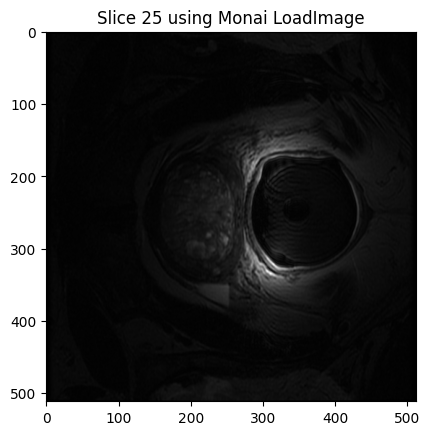

In [37]:
i=25
plt.imshow(monai_img[:, :, i], cmap="gray")
plt.title(f"Slice {i} using Monai LoadImage")

Using SimpleITK

In [38]:
img = sitk.ReadImage(test_mhd_path)

img_array = sitk.GetArrayFromImage(img)

Text(0.5, 1.0, 'Slice 25 using SimpleITK')

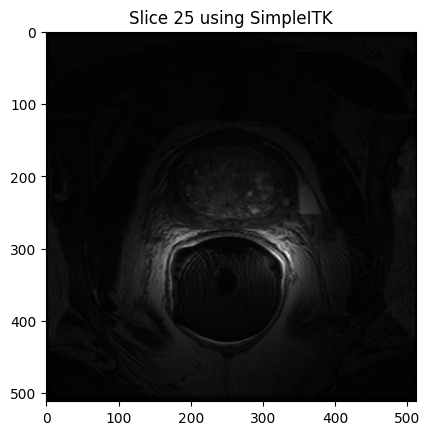

In [40]:
plt.imshow(img_array[i], cmap="gray")
plt.title(f"Slice {i} using SimpleITK")

Visualizing a Mask

In [41]:
test_mhd_mask_path = 'Case00_segmentation.mhd'

test_mask_path = data_dir + test_mhd_mask_path

In [42]:
load_mask = LoadImage(image_only=True, reader=ITKReader())
mask = load_mask(test_mask_path)

RuntimeError: LoadImage cannot find a suitable reader for file: data/PROMISE12/training_data/Case00_segmentation.mhd.
    Please install the reader libraries, see also the installation instructions:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies.
   The current registered: [<monai.data.image_reader.PydicomReader object at 0x7f69aef41990>, <monai.data.image_reader.ITKReader object at 0x7f69aef80110>, <monai.data.image_reader.NumpyReader object at 0x7f69aefa8210>, <monai.data.image_reader.PILReader object at 0x7f69af053b90>, <monai.data.image_reader.NibabelReader object at 0x7f69b00cbb10>, <monai.data.image_reader.ITKReader object at 0x7f69aff8d810>].
Traceback (most recent call last):
  File "/home/shane/miniconda3/envs/myenv/lib/python3.11/site-packages/itk/support/template_class.py", line 526, in __getitem__
    this_item = self.__template__[key]
                ~~~~~~~~~~~~~~~~~^^^^^
KeyError: (<itkCType signed char>, 3)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/shane/miniconda3/envs/myenv/lib/python3.11/site-packages/monai/transforms/io/array.py", line 268, in __call__
    img = reader.read(filename)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/home/shane/miniconda3/envs/myenv/lib/python3.11/site-packages/monai/data/image_reader.py", line 259, in read
    img_.append(itk.imread(name, **kwargs_))
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/shane/miniconda3/envs/myenv/lib/python3.11/site-packages/itk/support/extras.py", line 1387, in imread
    reader = template_reader_type.New(**kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/shane/miniconda3/envs/myenv/lib/python3.11/site-packages/itk/support/template_class.py", line 662, in New
    return self._NewImageReader(
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/shane/miniconda3/envs/myenv/lib/python3.11/site-packages/itk/support/template_class.py", line 192, in _NewImageReader
    ImageType = itk.Image[PixelType, dimension]
                ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "/home/shane/miniconda3/envs/myenv/lib/python3.11/site-packages/itk/support/template_class.py", line 530, in __getitem__
    raise itk.TemplateTypeError(self, key)
itk.support.extras.TemplateTypeError: itk.Image is not wrapped for input type `itk.SC, int`.

To limit the size of the package, only a limited number of
types are available in ITK Python. To print the supported
types, run the following command in your python environment:

    itk.Image.GetTypes()

Possible solutions:
* If you are an application user:
** Convert your input image into a supported format (see below).
** Contact developer to report the issue.
* If you are an application developer, force input images to be
loaded in a supported pixel type.

    e.g.: instance = itk.Image[itk.RGBPixel[itk.UC], int].New(my_input)

* (Advanced) If you are an application developer, build ITK Python yourself and
turned to `ON` the corresponding CMake option to wrap the pixel type or image
dimension you need. When configuring ITK with CMake, you can set
`ITK_WRAP_${type}` (replace ${type} with appropriate pixel type such as
`double`). If you need to support images with 4 or 5 dimensions, you can add
these dimensions to the list of dimensions in the CMake variable
`ITK_WRAP_IMAGE_DIMS`.

Supported input types:

itk.RGBPixel[itk.UC]
itk.RGBAPixel[itk.UC]
itk.Vector[itk.F,2]
itk.Vector[itk.F,3]
itk.Vector[itk.F,4]
itk.CovariantVector[itk.F,2]
itk.CovariantVector[itk.F,3]
itk.CovariantVector[itk.F,4]
itk.SS
itk.UC
itk.US
itk.F
itk.D
itk.complex[itk.D]
itk.complex[itk.F]
itk.Vector[itk.D,2]
itk.Vector[itk.D,3]
itk.Vector[itk.D,4]
itk.SI
itk.UI
itk.UL
itk.ULL
itk.B
itk.FixedArray[itk.F,2]
itk.FixedArray[itk.D,2]
itk.Offset[2]
itk.SymmetricSecondRankTensor[itk.D,2]
itk.SymmetricSecondRankTensor[itk.F,2]
itk.RGBPixel[itk.UC]
itk.RGBAPixel[itk.UC]
itk.Vector[itk.F,2]
itk.Vector[itk.F,3]
itk.Vector[itk.F,4]
itk.CovariantVector[itk.F,2]
itk.CovariantVector[itk.F,3]
itk.CovariantVector[itk.F,4]
itk.SS
itk.UC
itk.US
itk.F
itk.D
itk.complex[itk.D]
itk.complex[itk.F]
itk.Vector[itk.D,2]
itk.Vector[itk.D,3]
itk.Vector[itk.D,4]
itk.SI
itk.UI
itk.UL
itk.ULL
itk.B
itk.FixedArray[itk.F,3]
itk.FixedArray[itk.D,3]
itk.Offset[3]
itk.SymmetricSecondRankTensor[itk.D,3]
itk.SymmetricSecondRankTensor[itk.F,3]
itk.RGBPixel[itk.UC]
itk.RGBAPixel[itk.UC]
itk.Vector[itk.F,2]
itk.Vector[itk.F,3]
itk.Vector[itk.F,4]
itk.CovariantVector[itk.F,2]
itk.CovariantVector[itk.F,3]
itk.CovariantVector[itk.F,4]
itk.SS
itk.UC
itk.US
itk.F
itk.D
itk.complex[itk.D]
itk.complex[itk.F]
itk.Vector[itk.D,2]
itk.Vector[itk.D,3]
itk.Vector[itk.D,4]
itk.SI
itk.UI
itk.UL
itk.ULL
itk.B
itk.FixedArray[itk.F,4]
itk.FixedArray[itk.D,4]
itk.Offset[4]
itk.SymmetricSecondRankTensor[itk.D,4]
itk.SymmetricSecondRankTensor[itk.F,4]
itk.Vector[itk.F,1]
itk.Vector[itk.F,1]
itk.Vector[itk.D,2]
itk.Vector[itk.D,3]
itk.Vector[itk.D,4]
itk.Vector[itk.F,1]
itk.CovariantVector[itk.D,2]
itk.CovariantVector[itk.D,3]
itk.CovariantVector[itk.D,4]
itk.CovariantVector[itk.D,2]
itk.CovariantVector[itk.D,3]
itk.CovariantVector[itk.D,4]
itk.CovariantVector[itk.D,2]
itk.CovariantVector[itk.D,3]
itk.CovariantVector[itk.D,4]
itk.NormalBandNode[itk.Image[itk.F,2]]
itk.NormalBandNode[itk.Image[itk.D,2]]
itk.NormalBandNode[itk.Image[itk.F,3]]
itk.NormalBandNode[itk.Image[itk.D,3]]
itk.NormalBandNode[itk.Image[itk.F,4]]
itk.NormalBandNode[itk.Image[itk.D,4]]


Traceback (most recent call last):
  File "/home/shane/miniconda3/envs/myenv/lib/python3.11/site-packages/monai/transforms/io/array.py", line 268, in __call__
    img = reader.read(filename)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/home/shane/miniconda3/envs/myenv/lib/python3.11/site-packages/monai/data/image_reader.py", line 922, in read
    img = nib.load(name, **kwargs_)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/shane/miniconda3/envs/myenv/lib/python3.11/site-packages/nibabel/loadsave.py", line 118, in load
    raise ImageFileError(f'Cannot work out file type of "{filename}"')
nibabel.filebasedimages.ImageFileError: Cannot work out file type of "data/PROMISE12/training_data/Case00_segmentation.mhd"

Traceback (most recent call last):
  File "/home/shane/miniconda3/envs/myenv/lib/python3.11/site-packages/monai/transforms/io/array.py", line 268, in __call__
    img = reader.read(filename)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/home/shane/miniconda3/envs/myenv/lib/python3.11/site-packages/monai/data/image_reader.py", line 1179, in read
    img = PILImage.open(name, **kwargs_)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/shane/miniconda3/envs/myenv/lib/python3.11/site-packages/PIL/Image.py", line 3572, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file 'data/PROMISE12/training_data/Case00_segmentation.mhd'

Traceback (most recent call last):
  File "/home/shane/miniconda3/envs/myenv/lib/python3.11/site-packages/numpy/lib/npyio.py", line 465, in load
    return pickle.load(fid, **pickle_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
_pickle.UnpicklingError: invalid load key, 'O'.

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/shane/miniconda3/envs/myenv/lib/python3.11/site-packages/monai/transforms/io/array.py", line 268, in __call__
    img = reader.read(filename)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/home/shane/miniconda3/envs/myenv/lib/python3.11/site-packages/monai/data/image_reader.py", line 1082, in read
    img = np.load(name, allow_pickle=True, **kwargs_)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/shane/miniconda3/envs/myenv/lib/python3.11/site-packages/numpy/lib/npyio.py", line 467, in load
    raise pickle.UnpicklingError(
_pickle.UnpicklingError: Failed to interpret file 'data/PROMISE12/training_data/Case00_segmentation.mhd' as a pickle

Traceback (most recent call last):
  File "/home/shane/miniconda3/envs/myenv/lib/python3.11/site-packages/itk/support/template_class.py", line 526, in __getitem__
    this_item = self.__template__[key]
                ~~~~~~~~~~~~~~~~~^^^^^
KeyError: (<itkCType signed char>, 3)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/shane/miniconda3/envs/myenv/lib/python3.11/site-packages/monai/transforms/io/array.py", line 268, in __call__
    img = reader.read(filename)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/home/shane/miniconda3/envs/myenv/lib/python3.11/site-packages/monai/data/image_reader.py", line 259, in read
    img_.append(itk.imread(name, **kwargs_))
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/shane/miniconda3/envs/myenv/lib/python3.11/site-packages/itk/support/extras.py", line 1387, in imread
    reader = template_reader_type.New(**kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/shane/miniconda3/envs/myenv/lib/python3.11/site-packages/itk/support/template_class.py", line 662, in New
    return self._NewImageReader(
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/shane/miniconda3/envs/myenv/lib/python3.11/site-packages/itk/support/template_class.py", line 192, in _NewImageReader
    ImageType = itk.Image[PixelType, dimension]
                ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "/home/shane/miniconda3/envs/myenv/lib/python3.11/site-packages/itk/support/template_class.py", line 530, in __getitem__
    raise itk.TemplateTypeError(self, key)
itk.support.extras.TemplateTypeError: itk.Image is not wrapped for input type `itk.SC, int`.

To limit the size of the package, only a limited number of
types are available in ITK Python. To print the supported
types, run the following command in your python environment:

    itk.Image.GetTypes()

Possible solutions:
* If you are an application user:
** Convert your input image into a supported format (see below).
** Contact developer to report the issue.
* If you are an application developer, force input images to be
loaded in a supported pixel type.

    e.g.: instance = itk.Image[itk.RGBPixel[itk.UC], int].New(my_input)

* (Advanced) If you are an application developer, build ITK Python yourself and
turned to `ON` the corresponding CMake option to wrap the pixel type or image
dimension you need. When configuring ITK with CMake, you can set
`ITK_WRAP_${type}` (replace ${type} with appropriate pixel type such as
`double`). If you need to support images with 4 or 5 dimensions, you can add
these dimensions to the list of dimensions in the CMake variable
`ITK_WRAP_IMAGE_DIMS`.

Supported input types:

itk.RGBPixel[itk.UC]
itk.RGBAPixel[itk.UC]
itk.Vector[itk.F,2]
itk.Vector[itk.F,3]
itk.Vector[itk.F,4]
itk.CovariantVector[itk.F,2]
itk.CovariantVector[itk.F,3]
itk.CovariantVector[itk.F,4]
itk.SS
itk.UC
itk.US
itk.F
itk.D
itk.complex[itk.D]
itk.complex[itk.F]
itk.Vector[itk.D,2]
itk.Vector[itk.D,3]
itk.Vector[itk.D,4]
itk.SI
itk.UI
itk.UL
itk.ULL
itk.B
itk.FixedArray[itk.F,2]
itk.FixedArray[itk.D,2]
itk.Offset[2]
itk.SymmetricSecondRankTensor[itk.D,2]
itk.SymmetricSecondRankTensor[itk.F,2]
itk.RGBPixel[itk.UC]
itk.RGBAPixel[itk.UC]
itk.Vector[itk.F,2]
itk.Vector[itk.F,3]
itk.Vector[itk.F,4]
itk.CovariantVector[itk.F,2]
itk.CovariantVector[itk.F,3]
itk.CovariantVector[itk.F,4]
itk.SS
itk.UC
itk.US
itk.F
itk.D
itk.complex[itk.D]
itk.complex[itk.F]
itk.Vector[itk.D,2]
itk.Vector[itk.D,3]
itk.Vector[itk.D,4]
itk.SI
itk.UI
itk.UL
itk.ULL
itk.B
itk.FixedArray[itk.F,3]
itk.FixedArray[itk.D,3]
itk.Offset[3]
itk.SymmetricSecondRankTensor[itk.D,3]
itk.SymmetricSecondRankTensor[itk.F,3]
itk.RGBPixel[itk.UC]
itk.RGBAPixel[itk.UC]
itk.Vector[itk.F,2]
itk.Vector[itk.F,3]
itk.Vector[itk.F,4]
itk.CovariantVector[itk.F,2]
itk.CovariantVector[itk.F,3]
itk.CovariantVector[itk.F,4]
itk.SS
itk.UC
itk.US
itk.F
itk.D
itk.complex[itk.D]
itk.complex[itk.F]
itk.Vector[itk.D,2]
itk.Vector[itk.D,3]
itk.Vector[itk.D,4]
itk.SI
itk.UI
itk.UL
itk.ULL
itk.B
itk.FixedArray[itk.F,4]
itk.FixedArray[itk.D,4]
itk.Offset[4]
itk.SymmetricSecondRankTensor[itk.D,4]
itk.SymmetricSecondRankTensor[itk.F,4]
itk.Vector[itk.F,1]
itk.Vector[itk.F,1]
itk.Vector[itk.D,2]
itk.Vector[itk.D,3]
itk.Vector[itk.D,4]
itk.Vector[itk.F,1]
itk.CovariantVector[itk.D,2]
itk.CovariantVector[itk.D,3]
itk.CovariantVector[itk.D,4]
itk.CovariantVector[itk.D,2]
itk.CovariantVector[itk.D,3]
itk.CovariantVector[itk.D,4]
itk.CovariantVector[itk.D,2]
itk.CovariantVector[itk.D,3]
itk.CovariantVector[itk.D,4]
itk.NormalBandNode[itk.Image[itk.F,2]]
itk.NormalBandNode[itk.Image[itk.D,2]]
itk.NormalBandNode[itk.Image[itk.F,3]]
itk.NormalBandNode[itk.Image[itk.D,3]]
itk.NormalBandNode[itk.Image[itk.F,4]]
itk.NormalBandNode[itk.Image[itk.D,4]]


Traceback (most recent call last):
  File "/home/shane/miniconda3/envs/myenv/lib/python3.11/site-packages/monai/transforms/io/array.py", line 268, in __call__
    img = reader.read(filename)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/home/shane/miniconda3/envs/myenv/lib/python3.11/site-packages/monai/data/image_reader.py", line 491, in read
    ds = pydicom.dcmread(fp=name, **kwargs_)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/shane/miniconda3/envs/myenv/lib/python3.11/site-packages/pydicom/filereader.py", line 1078, in dcmread
    dataset = read_partial(
              ^^^^^^^^^^^^^
  File "/home/shane/miniconda3/envs/myenv/lib/python3.11/site-packages/pydicom/filereader.py", line 839, in read_partial
    preamble = read_preamble(fileobj, force)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/shane/miniconda3/envs/myenv/lib/python3.11/site-packages/pydicom/filereader.py", line 784, in read_preamble
    raise InvalidDicomError(
pydicom.errors.InvalidDicomError: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


In [43]:
mask_img = sitk.ReadImage(test_mask_path)

mask_array = sitk.GetArrayFromImage(mask_img)

In [44]:
mask_array.shape

(47, 512, 512)

Text(0.5, 1.0, 'Slice 25 Mask')

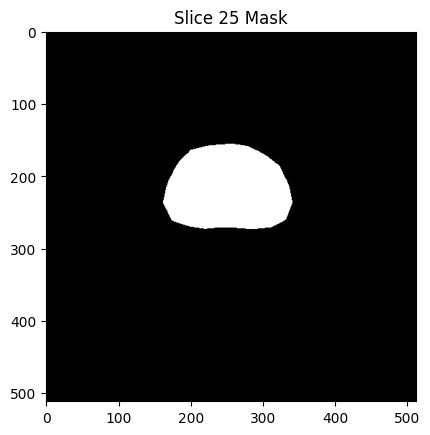

In [45]:
plt.imshow(mask_array[i], cmap="gray")
plt.title(f"Slice {i} Mask")

## Data Loading to prepare for training

TO do:

Reminder to convert the shape from MONAI ITK from H,W,D to D,H,W to match the mask format.
OR make use of SImpleITK for reading in the images, and then pushing to MONAI for data processing and training

MONAI will require the arrays to be in tensors so use .ToTensor() transformation

It is part of Monai 

from monai.transforms import ToTensor 

[Monai Documenation on Transforms](https://docs.monai.io/en/stable/transforms.html)